In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


In [2]:
!nvidia-smi

Fri Jan  7 01:11:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화


print(tf.__version__)

2.4.1


In [4]:
def positional_encoding(pos_len, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos_len)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:,0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:,1::2])
    return sinusoid_table
    

In [88]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scale_dot_product_attention(self, Q, K, V, mask=None):
        d_k = tf.cast(K.shape[-1], tf.float32)
        # scaled qk 구하기

        QK_T = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK_T / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, *xs): # num_heads는 self에 있으니까 받을 필요 없음
        # MultiHead에 넣을려고 분할
        # x: [ batch x length x embedding_dimension ]
        # return: [ batch x heads x length x embedding_dimension]
        split_xs = []
        for x in xs:
            a,b,c = x.shape

            split_x = tf.reshape(x,(a,b,self.num_heads,self.depth))
            split_x = tf.transpose(split_x, (0,2,1,3))            
            split_xs.append(split_x)
            
        return split_xs


    def combine_heads(self, x):
        # 분할 계산을 마치고, 임베딩을 다시 결합한다.
        # x: [ batch x heads x length x depth ]
        # return: [ batch x length x emb ]
        x = tf.transpose(x,(0,2,1,3))
        a,b,c,d = x.shape

        concat_x = tf.reshape(x, (a,b,c*d))

        return concat_x


    def call(self, Q, K, V, mask=None): #[batch x len x 512 ]
        # 1: Linear_in(Q,K,V) -> WQ, WK, WV
        wq = self.W_q(Q)
        wk = self.W_k(K)
        wv = self.W_v(V)

        # 2: split heads
        W_qkv_split = self.split_heads(wq,wk,wv)

        # 3: scaled dot product attention
        out, attention_weights = self.scale_dot_product_attention(*W_qkv_split, mask)

        # 4: Combine Heads(out) -> out
        out = self.combine_heads(out)

        # 5: Linear_out(out) -> out
        out = self.linear(out)

        return out, attention_weights



In [89]:
class Position_wise_FFN(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(Position_wise_FFN, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self,x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out


In [90]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = Position_wise_FFN(d_model,d_ff)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        # Multi-Head Attention
        residual = x

        out = self.norm1(x)
        out, enc_attn = self.enc_self_attn(out,out,out, mask)
        out = self.dropout(out)

        out += residual

        # position wise FFN
        residual2 = out
        out = self.norm2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual2

        return out, enc_attn



In [91]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.dec_attn = MultiHeadAttention(d_model, n_heads)

        self.ffn = Position_wise_FFN(d_model,dff)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x,y, causality_mask, padding_mask):
        residual = x
        out = self.norm1(x)
        out, dec_attn = self.dec_self_attn(out,out,out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm2(out)
        out, dec_enc_attn = self.dec_attn(out,y,y, causality_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm3(out)
        out = self.ffn(out)
        out += residual

        return out, dec_attn, dec_enc_attn



In [92]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 dff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model,n_heads,dff,dropout) for _ in range(n_layers)]

    def call(self, x, mask):
        out = x

        enc_attns = []

        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns
        

In [93]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, dff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model,n_heads, dff, dropout) for i in range(n_layers)]

    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        
        dec_attns = []
        dec_enc_attns = []

        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out,enc_out, causality_mask, padding_mask)
            
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
        

In [104]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers,d_model,
                 n_heads,dff,src_vocab_size,
                 tgt_vocab_size, pos_len,
                 dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.positional = positional_encoding(pos_len,d_model)

        self.encoder = Encoder(n_layers, d_model, n_heads, dff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, dff, dropout)
        
        self.out_linear = tf.keras.layers.Dense(tgt_vocab_size)
        self.dropout = dropout

        self.shared = shared

        if shared: self.out_linear.set_weights(tf.transpose(self.dec_embedding.weights))

    
    def embedding(self, emb, x):
        # share?
        seq_len = x.shape[1]
        out = emb(x)
        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.positional[np.newaxis, ...][:, :seq_len, :]

        return out

    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # 1 embedding
        enc = self.embedding(self.enc_embedding, enc_in)
        dec = self.embedding(self.dec_embedding, dec_in)

        # 2 encoder, decoder
        enc_out, enc_attns = self.encoder(enc, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(dec, enc_out, causality_mask, dec_mask)

        logits = self.out_linear(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns



In [105]:

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


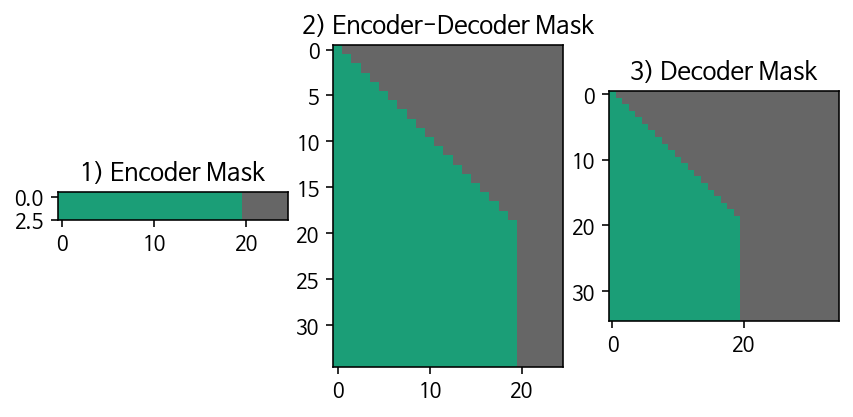

In [74]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [106]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)



In [76]:
now_path = "aiffel/Data/kor_en/"
path_to_enfile = "data/kor_en/korean-english-park.train.en"
path_to_kofile = "data/kor_en/korean-english-park.train.ko"
kor_path = now_path + path_to_enfile
eng_path = now_path + path_to_kofile

In [77]:

# 데이터 정제
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.readlines()
    with open(eng_path, "r") as f: eng = f.readlines()
    assert len(kor) == len(eng)
    print(len(kor))
    
    dataset = set()
    for i,j in zip(kor, eng):
        i = preprocess_sentence(i)
        j = preprocess_sentence(j)
        dataset.add((i,j))
    print(len(dataset))
    cleaned_corpus = list(dataset)
    return cleaned_corpus

In [ ]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'([?!,."])', r' \1 ',sentence)
    sentence = re.sub(r'[^A-zㄱ-ㅎㅏ-ㅣ가-힣0-9?!,."]', ' ', sentence)
    sentence = re.sub(r'[" "]+', ' ',sentence)
    sentence = sentence.strip()
    return sentence

cleaned_corpus = clean_corpus(kor_path, eng_path)


94123
78966


In [79]:
import sentencepiece as spm
import os

def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    path = 'aiffel/Data/Model/transformer/'
    temp_file = f'{path}corpus_{lang}.temp'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix={path}spm_{lang} --vocab_size={vocab_size} --model_type=bpe'
    )
    
    s = spm.SentencePieceProcessor()
    s.Load(f'{path}spm_{lang}.model')
    print(f"{lang}-dict_num: {20000}")

    return s

In [80]:
eng, kor = zip(*cleaned_corpus)
print(kor[0])
ko = generate_tokenizer(kor,20000)
en = generate_tokenizer(eng,20000, lang="en")

올해 50세의 베어백 코치는 2002년 한일 월드컵에서 거스 히딩크 감독을 도와 대표팀의 4강 신화를 일궈낸 주역으로 , 잠시 휴식을 취한 후 업무를 시작할 예정이다 .  
ko-dict_num: 20000
en-dict_num: 20000


In [126]:
def tokenize(corpus, tensorlen,voca_size):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=voca_size,filters='',)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=tensorlen)

    return tensor, tokenizer

In [127]:

path = 'aiffel/Data/Model/transformer/'
temp_file = f'{path}corpus_ko.temp'
ko_seq = []
with open(temp_file,'r') as f:
    for i in f.readlines():
        ko_seq.append(ko.SampleEncodeAsPieces(i,1, 0.0))
ko_tensor, ko_tokenizer = tokenize(ko_seq,50,20000)
print(ko_seq[0])
en_seq = []
temp_file = f'{path}corpus_en.temp'
with open(temp_file,'r') as f:
    for i in f.readlines():
        en_seq.append(en.SampleEncodeAsPieces(i,1, 0.0))
en_tensor, en_tokenizer = tokenize(en_seq,50,20000)
print(en_seq[0])

['▁올해', '▁50', '세의', '▁베어', '백', '▁코', '치는', '▁2002', '년', '▁한일', '▁월드컵', '에서', '▁거', '스', '▁히', '딩', '크', '▁감독을', '▁도와', '▁대표팀', '의', '▁4', '강', '▁신', '화를', '▁일', '궈', '낸', '▁주', '역', '으로', '▁,', '▁잠시', '▁휴식을', '▁취한', '▁후', '▁업무를', '▁시작할', '▁예정이다', '▁.']
['▁ver', 'bee', 'k', '▁will', '▁start', '▁his', '▁new', '▁job', '▁after', '▁a', '▁short', '▁break', '▁from', '▁this', '▁weekend', '▁.']


In [128]:
print(f"ko dict voca: {len(ko_tokenizer.index_word)}")
print(f"en dict voca: {len(en_tokenizer.index_word)}")


ko dict voca: 20288
en dict voca: 19065


In [129]:
print(len(ko_seq), len(en_seq))
print(ko_seq[1], en_seq[1])

78966 78966
['▁내', '▁블로그에', '▁저장', '▁가상', '▁세계', '▁결혼', '관계가', '▁현실', '로'] ['▁she', '▁was', '▁about', '▁to', '▁meet', '▁someone', '▁she', '▁had', '▁been', '▁chatting', '▁with', '▁online', '▁since', '▁february', '▁.']


In [130]:
en_tensor.shape

(78966, 50)

In [131]:
from sklearn.model_selection import train_test_split

BUFFER_SIZE = 64
BATCH_SIZE = 64

enc_train, enc_val, dec_train, dec_val = \
train_test_split(en_tensor, ko_tensor, test_size=0.2)





dataset = tf.data.Dataset.from_tensor_slices((enc_train,dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((64, 50), (64, 50)), types: (tf.int32, tf.int32)>


<BatchDataset shapes: ((64, 50), (64, 50)), types: (tf.int32, tf.int32)>

In [132]:
train = dataset.__iter__()


In [49]:
next(train)[0].shape

TensorShape([64, 50])

In [119]:
transformer = Transformer(2,512,4,2048,20289,20001,50,shared=False)

# 와... 위대하다.
### 여기서 오류가 얼마나 떴는지 모르겠다.
### super은 init이라는 메소드가 없다는 부분부터, pos가 정의되지 않았다는 내용 등등. 아주 뿌듯하다.

In [120]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [121]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [122]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [123]:
# ex = '''오바마는 대통령이다.
# 시민들은 도시 속에 산다.
# 커피는 필요 없다.
# 일곱 명의 사망자가 발생했다.'''
# ex = ex.split('\n')
# corpus = []
# for i in ex:
#     corpus.append(ko.SampleEncodeAsPieces(i,1, 0.0))
# for i in corpus:
#     print(i)
# tensor = ko_tokenizer.texts_to_sequences(corpus)

# tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=50)
# print(tensor)


In [124]:

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## 문장이 짧아서 오히려 잘 안될지도 모른다는 걱정이 들지만, 논리적이지 않은 걱정인 것 같습니다..ㅎㅎ

In [134]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns



# def evaluate(tgt, model):
#     ids = []
#     output = tf.expand_dims([en.bos_id()], 0)

#     for i in range(tgt.shape[-1]):
#         enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(corpus, output)
    
#         predict, _1, _2, _3 = model(corpus, output, enc_padding_mask, combined_mask, dec_padding_mask)

#         predicted_id = tf.argmax(tf.math.softmax(predict, axis=-1)[0,-1]).numpy().item()

#         if en.eos_id()== predicted_id:
#             result = en.decode_ids(ids)
#             return result, _1, _2, _3

#         ids.append(predicted_id)
#         output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

#     result = en.decode_ids(ids)

#     return result, _1, _2, _3

def eval_step(src,tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src,tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src,tgt,enc_mask, dec_enc_mask, dec_mask)
    val_loss = loss_function(gold, predictions[:, :-1])
    
    
    return val_loss, enc_attns, dec_attns, dec_enc_attns

from tqdm.notebook import tqdm

BATCH_SIZE = 64
EPOCHS = 20



for epoch in range(EPOCHS):
    total_loss = 0
    val_loss = 0
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))[:-4]
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    train = dataset.__iter__()
    val = val_dataset.__iter__()

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(*next(train),
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))


    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))[:-4]
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            eval_step(*next(val),
                       transformer,
                       optimizer)
        
        val_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (val_loss.numpy() / (batch + 1)))

    for ex in examples:
        translate(ex, transformer, ko, en)












  0%|          | 0/984 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/984 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: were former
Input: 시민들은 도시 속에 산다.
Predicted translation: outr spreadreare medu wereity pydu a
Input: 커피는 필요 없다.
Predicted translation: were former
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: were former


  0%|          | 0/984 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: were factare were factare were factareare py
Input: 시민들은 도시 속에 산다.
Predicted translation: were
Input: 커피는 필요 없다.
Predicted translation: were wereencencencencencencencenc tim sept sept sept were factare wereenc py
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: investments


  0%|          | 0/984 [00:00<?, ?it/s]

KeyboardInterrupt: 